# BOMR 2021

Ludovic Dauvin, 288 407 <br>
Théo Stanislaw Gieruc, 282 360 <br>
Jonathan Henry, 287 725 <br>
Guillaume Eliot Krafft, 289 256 <br>




## Introduction

Starting the project we first decided which algorithms we wanted to use. 
Concerning the global navigation, we chose to use a visibility graph combined with the Dijkstra algorithm to find the shortest path. 
For the filtering part, we used a Kalman filter and for the local avoidance we used a Braintenberg approche.
We then designed the setup in which the robot would move. 
The floor is white in order to have a good contrast with the other elements. We chose red, green and blue to easily detect the elements with rgb values :
<ul>
<li> Red represents the robot, therefore we sticked a red triangle on top of the thymio.
<li> Green was chosen to represent the goal.
<li> Blue is used to represnet the different shaped fixed obstacles.
</ul>
We use a white cylinder as a mobile obstacle for local avoidance.<br>
A lectern and a handcrafted cardboard arm were used in order to place the camera on top of the playing field with a centered view. 


## Module description 

### Vision

### Global Navigation 

### Filtering

### Local Navigation

The local avoidance of obstacles is done through the use of an ANN (Artificial Neural Network).<br>
In our case we have a single layer neural network composed of two neurons. We feed them the values of the 5 front sensors and they output a speed for each motor in order to avoid the obstacle. We also added a memory which helps the thymio continue moving despite the lack of input from the sensors once the obstacle is partially avoided.

The function is located in 'src/movement' 

In [ ]:
prox_and_memory = np.zeros(7)
k_ann = 1500
offset_ann = 150

def local_avoid(speed_robot, node):
    # global prox_and_memory
    prox_and_memory[0:5] = np.array([x for x in node['prox.horizontal'][0:5]])
    w= np.array([[80, 20, -25, -20, -80, 12, 0],[-80, -20, -20, 20, 80, 0, 12]])
    v= w.dot(prox_and_memory)
    if (abs(v) > 2200).any():
        prox_and_memory[5] = 0
        prox_and_memory[6] = 0
        speed_robot = (v / k_ann).astype(int) + offset_ann
    else:
        speed_robot += (v / 200).astype(int)

    prox_and_memory[5:7] = (speed_robot / 10).astype(int)

    return speed_robot

The function takes as input speed_robot, which is the speed calculated thanks to the other modules (vision and kalman filter)

The weights of the neurons are set in the variable w and were manually tweaked to correctly avoid obstacles. The last two values are used for the memory.

The if statment is there to distinguish two cases : 
<ol>
<li>If the robot is close to the obstacle, it only avoids the object, the speed_robot is completely overwritten by the local avoidance.
<li>If the robot is far enough we add the output of the neurons to robot_speed therfore the robot still wants to go back on its planned trajectory. 

#### runable code (using the thymio) 

The following code is taken from TP3 and can be used to demonstarte the working principle of the ANN. Note that here the code is transpiled in aseba and loaded on the thymio. In the project the sensors values are passed using ClientAsync more on that in the motion control part of this report.

In [1]:
!pip install --upgrade tdmclient

  Attempting uninstall: tdmclient
    Found existing installation: tdmclient 0.1.11
    Uninstalling tdmclient-0.1.11:
      Successfully uninstalled tdmclient-0.1.11


In [2]:
import tdmclient.notebook
await tdmclient.notebook.start()

In [4]:
%%run_python 

# This program implements obstacle avoidance using an ANN
# The inputs x1-7 are taken from the proximity sensors and scaled
# The inputs are multiplied by the weights 
#   and used to set the motor powers
# The center button starts and stops the robot

# State for start and stop, why is this instruction here? (hint: look at the aseba transpile code)
state = 1
y = [0,0]  

@onevent
def button_center():
    global state
    if button_center == 1:
        state = 1 if state==0 else 0

@onevent
def prox():
    global prox_horizontal, motor_left_target, motor_right_target, button_center, state, y 

    w_l = [40,  20, -20, -20, -40,  30, -10, 8, 0]
    w_r = [-40, -20, -20,  20,  40, -10, 30, 0, 8]

    # Scale factors for sensors and constant factor
    sensor_scale = 200
    constant_scale = 20
    
    x = [0,0,0,0,0,0,0,0,0]
    
    if state != 0:
        # Memory
        x[7] = y[0]//10
        x[8] = y[1]//10
        
        for i in range(7):
            # Get and scale inputs
            x[i] = prox_horizontal[i] // sensor_scale
        
        y = [0,0]    
        
        for i in range(len(x)):    
            # Compute outputs of neurons and set motor powers
            y[0] = y[0] + x[i] * w_l[i]
            y[1] = y[1] + x[i] * w_r[i]
    else: 
        # In case we would like to stop the robot
        y = [0,0] 
    
    # Set motor powers
    motor_left_target = y[0]
    motor_right_target = y[1]

In [5]:
await tdmclient.notebook.stop()

### Motion Control/movement 

The different functions disccused further down are located in 'src/movement.py'

#### clientAsync

We decided to use clientAsync to pass speed values to and from the thymio, because it was a better options in terms of speed and simplicity than having to create custom events and using event based programming directly on the thymio. 

##### runable code (using the thymio) 

In [1]:
from tdmclient import ClientAsync
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()
await node.wait_for_variables()

start the robot

In [8]:
#set_speed 
speed_robot = [100,-100]
v = {
    "motor.left.target":  [speed_robot[0]],
    "motor.right.target": [speed_robot[1]],
}
await node.set_variables(v)

measure the robot's speed 

In [9]:
#get_speed
right_speed = node['motor.right.speed']
left_speed = node['motor.left.speed']
print('left speed :',left_speed,'right speed :',right_speed)

left speed : 98 right speed : -99


stop the robot

In [10]:
#set_speed 
speed_robot = [0,0]
v = {
    "motor.left.target":  [speed_robot[0]],
    "motor.right.target": [speed_robot[1]],
}
await node.set_variables(v)

#### compute_speed()

The last part of movement we havent discussed is the compute_speed() function. 

In [ ]:
def compute_speed(vision, actual_pos, target_pos, min_angle, offset_speed, k_forward, k_rot, is_near_checkpoint):
    wheel_radius = utils.WHEEL_RADIUS_MM * vision.mm2px
    robot_width  = utils.THYMIO_WIDTH_MM * vision.mm2px
    delta_pos = target_pos - actual_pos[0:2]
    alpha = -actual_pos[2] + np.arctan2(delta_pos[1], delta_pos[0])
    alpha = (alpha + np.pi) % (2 * np.pi) - np.pi
    if (abs(alpha) > min_angle) & is_near_checkpoint:
        return [int( k_rot * alpha * robot_width / 2 / wheel_radius),
                int(-k_rot * alpha * robot_width / 2 / wheel_radius)]
    else:
        speed_left  = offset_speed + k_forward * alpha
        speed_right = offset_speed - k_forward * alpha
        speed = [int(speed_left), int(speed_right)]
        return speed

## Overall project execution

### Dependency installation

In [1]:
!pip install --quiet opencv-python tqdm matplotlib numpy ipywidgets imutils
!jupyter nbextension enable --py widgetsnbextension
!pip install --quiet --upgrade tdmclient

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


### Imports


In [1]:
import sys as _sys
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import Layout, Box,ColorPicker
from time import sleep, time
from PIL import ImageColor
from IPython.display import clear_output

_sys.path.append("./src")
from global_navigation import Path_planner
from vision import Vision
from visualizer import *
from movement import *
from Kalman_filter import Kalman_filter

%matplotlib inline

### Thymio connection

In [2]:
from tdmclient import ClientAsync, aw
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()
await node.wait_for_variables()

### Widget & utils function definition

In [3]:
def pltshow(img):
    clear_output(wait = True)
    plt.imshow(img)
    plt.show()
    
robot_cp = ColorPicker(
    concise=False,
    description='Robot',
    value='#c55a55',
    disabled=False
)
obstacles_cp = ColorPicker(
    concise=False,
    description='Obstacles',
    value='#2b7384',
    disabled=False
)
goal_cp = ColorPicker(
    concise=False,
    description='Goal',
    value='#669553',
    disabled=False
)


items_layout = Layout( width='auto')     # override the default width of the button to 'auto' to let the button grow

box_layout = Layout(display='flex',
                    flex_flow='column',
                    align_items='stretch',
                    width='100%')

items = [robot_cp, goal_cp, obstacles_cp]
box_cp = Box(children=items, layout=box_layout)




# Camera

In [4]:
vision = Vision()
vision.connect_camera(0)

### Calibration of exposure and contrast
> The image needs to be lit uniformly and each color has to be as homogenous as possible

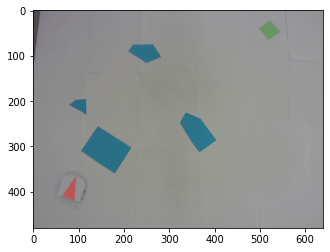

In [5]:
vision.vc.set(15,-5) #exposure
vision.vc.set(11,0) #contrast

for i in range(10):
    sleep(0.1)
    vision.update_frame()

im = plt.imshow(vision.actual_frame)

### Calibration of colors and thresholds
> The color of each element has to be set. 
> The threshold depends on the uniformity of each color

In [6]:
box_cp

Box(children=(ColorPicker(value='#c55a55', description='Robot'), ColorPicker(value='#669553', description='Goa…

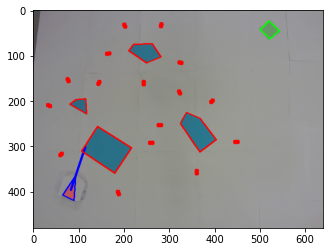

In [7]:
''' Color Calibration '''
robot_color = np.array(ImageColor.getcolor(robot_cp.value, "RGB"))
goal_color = np.array(ImageColor.getcolor(goal_cp.value, "RGB"))
obstacles_color = np.array(ImageColor.getcolor(obstacles_cp.value, "RGB"))

vision.set_colors(obstacles_color, robot_color, goal_color)

''' Threshold Calibration '''
goalthresh = 20
robotthresh = 30
obstaclesthresh = 20
vision.set_threshold(goalthresh, robotthresh, obstaclesthresh)

vision.update()
pltshow(vision.create_full_mask())

## set mm to px

In [8]:
vision.set_mm2px()

mm/px ratio :  0.4795240236160778



# Path planning

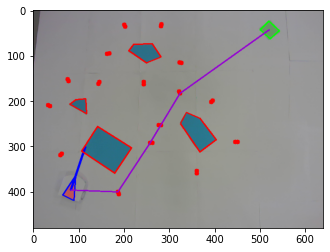

In [9]:
path_planner = Path_planner()
path_planner.make_path(vision)
pltshow(get_visualization_vision_path(vision, path_planner))

# Run

In [17]:
set_speed([0,0], node)

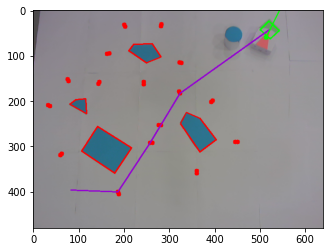

arrived at destination


In [11]:
'''Initialization'''
plt.figure()
vision.update_frame()
vision.update_frame()
vision.update_robot()
kalman = Kalman_filter(vision)
next_point_id = 1
next_point = path_planner.path[next_point_id]
min_dist = 30
time_prev = time()
min_angle = 0.3
offset_speed= 360
k_forward = 230
k_rot = 120
pltshow(get_visualization_vision_path_kalman(vision, path_planner,kalman))
sleep(2)
'''Run until is arrived at destination''' 
while 1:
    vision.update_frame()
    vision.update_robot()
    robot_speed = get_speed(node)
    kalman.update_kalman(vision, robot_speed, time() - time_prev)
    time_prev = time()
    
    pos = kalman.rho_est
    speed_robot = compute_speed(vision, pos, next_point, min_angle, offset_speed, k_forward, k_rot, (np.linalg.norm(pos[:2] - path_planner.path[next_point_id-1].flatten()) < min_dist))
    speed_robot = local_avoid(speed_robot, node)
    set_speed(speed_robot, node)

    pltshow(get_visualization_vision_path_kalman(vision, path_planner,kalman))

    '''Behaviour at checkpoints'''
    if np.linalg.norm(pos[:2] - next_point.flatten()) < min_dist:
        if next_point_id == len(path_planner.path) - 1:
            print("arrived at destination")
            set_speed([0,0], node)
            break
        else:
            next_point_id += 1
            next_point = path_planner.path[next_point_id]


In [9]:
 vision.disconnect_camera()

## Conclusion

In this project we have created different components that are vision, flitering, motion control, global and local navigation, and correctly connected them whith each other. Our project is functional and the thymio is capable of reaching its objective, while staying on the optimal path and avoiding obstacles through global navigation and local avoidance. We have been able to put in practice different techniques we have seen during the semester in the Basics Of Mobile Robotics course. <br>
It was an interesting project both in terms of techincal aspects and in term of organisation : creating from the ground up an entire project on a relatively short period of time required us to do some compromises. Nontheless the project works well on a wide variety of tests.   